In [ ]:
'''
I aim to create a Twitter Spark stream & save locally tweets to do with current major political figures
(Bernie, Trump, AOC, Biden) that have a sentiment greater than 0.25 (very positive) or less than -0.25
(very negative).

PySpark code lifted from #Laurent Weichberger, Big Data Bear, and his LinkedIn blog:
https://www.linkedin.com/pulse/apache-spark-streaming-twitter-python-laurent-weichberger

(tutorial on PySpark stream, but sentiment analysis and tweet analysis is my own input)
'''

In [ ]:
# TweetRead.py
# When executed, TweetRead.py will wait on localhost:8049 until the next script (SparkMod.py) runs
# This first python script doesn’t use Spark at all and should be run in separate terminal:
import os
import tweepy
from tweepy import OAuthHandler
from tweepy import Stream
from tweepy.streaming import StreamListener
import socket
import json
 
consumer_key=""
consumer_secret=""
access_token=""
access_secret=""

 
class TweetsListener(StreamListener):
    #Defines what to do with Stream Status objects
    def __init__(self, csocket):
        self.client_socket = csocket
 
    def on_data(self, data):
        try:
            print(data.split('\n'))
            self.client_socket.sendAll(data)
            return(True)
        except BaseException as e:
            print("Error on_data: %s" % str(e))
        return(True)
 
    def on_error(self, status):
        print(status)
        return(True)
 
def sendData(c_socket):
    # Makes Stream
    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_secret)
 
    twitter_stream = Stream(auth, TweetsListener(c_socket))
    #twitter_stream.filter(track=['AOC','Trump','Bernie','Biden']) #We want to track top political figures as of 3/5/19
     twitter_stream.filter(track=['Michael Jackson','MJ','King of Pop','Moonwalk'])
        
if __name__ == "__main__":
    s = socket.socket()     # Create a socket object
    host = "localhost"      # Get local machine name
    port = 8050             # Reserve a port for your service.
    s.bind((host, port))    # Bind to the port
 
    print("Listening on port: %s" % str(port))
 
    s.listen(5)                 # Now wait for client connection.
    c, addr = s.accept()        # Establish connection with client.
 
    print( "Received request from: " + str( addr ) )
 
    sendData( c )

In [ ]:
# SparkDemo.py
import json
import time
import tweepy
from textblob import TextBlob #for sentiment analysis
from pyspark import SparkContext
from pyspark.streaming import StreamingContext

# filter function
def filter_tweets(tweet):
    json_tweet = json.loads(tweet)
    if (('retweeted_status' in json_tweet)==False): # We only want original tweets
        twt = json_tweet["text"]
        analysis = TextBlob(twt)
        # We don't want tweets that are lukewarm in sentiment; only the very positive/negative
        if (abs(analysis.sentiment[0]) > 0.25 ): 
            return True # filter() requires a Boolean value
    return False

# SparkContext(“local[1]”) would not work with Streaming bc 2 threads are required
#sc = SparkContext("local[2]", "Twitter Demo")
sc = SparkContext.getOrCreate()
ssc = StreamingContext(sc, 10) #10 is the batch interval in seconds
IP = "localhost"
Port = 8049
lines = ssc.socketTextStream(IP, Port)

# Save each RDD as a new directory with the time as its name
#coalesce(1) ensures the saved RDD has only one partition
savePath = "/home/nyasarturk1/Documents/midterm/twitter"
lines.foreachRDD(lambda rdd: rdd.filter( filter_tweets ).coalesce(1).saveAsTextFile(savePath+"/tweets/%s" % (time.strftime("%H:%M:%S"))) )
# We cannot write to textFiles as we have concurrent threads due to the RDD making directories; output otherwise
#would be disastrous

# You must start the Spark StreamingContext, and await process termination (close terminal, restart kernel)
ssc.start()
ssc.awaitTermination()
# There will be errors! Ignore them.

In [33]:
# After collecting tweets, analyze the output.
import json
from textblob import TextBlob
# The directory structure looks like this: ~./midterm/twitter/ -> tweets/ -> 
#(directories named in hour:minutes:seconds format) -> (2 files: "_Success" (empty) and "part-00000.txt" (which has the
#tweet Status objects separated by a newline.))

# Iterate through directory, calculate average sentiment per tracked tag (Bernie, Biden, AOC, Trump)
savePath = "/home/nyasarturk1/Documents/midterm/twitter"
dPath = (savePath + "/tweets/")
# vars to store total counts of tweets to do with each tracked tag in above respective order,
#then cummulative sentiment and then average sentiment
tBr, cBr, aBr =0,0,0 #Bernie Sanders
tBd, cBd, aBd =0,0,0 #Joe Biden
tAo, cAo, aAo =0,0,0 #Alexandria Ocasio-Cortez
tTr, cTr, aTr =0,0,0 #Donald Trump

##print(os.getcwd())
os.chdir(dPath)
##print(os.getcwd())


# Function to extract tweet text from line of file
def get_twt(line):
    aftTxt = line.split("\"text\":\"")[1]
    p1 = ("\"source\":")
    p2 = ("\"display_text_range\":")
    if (p2 in aftTxt):
        # Split again at disp, tweet text is prior portion
        twt = aftTxt.split(p2)[0]
    else:
        # We just have "text": ..... "src":
        twt = aftTxt.split(p1)[0]
    return(twt)
        

# Function to return total tracked tag tweets from file as list
def get_tot(filePath):
    t =[0,0,0,0]
    with open(filePath) as f:
        for line in f:
            txt = get_twt(line).lower()
            if (('bernie' in txt) or ('sanders' in txt)):
                t[0] = t[0] + 1
            if (('joe' in txt) or ('biden' in txt)):
                t[1] = t[1] + 1
            if (('alexandria' in txt) or ('aoc' in txt) or ('cortez' in txt)):
                t[2] = t[2] + 1
            if (('trump' in txt) or ('donald' in txt)):
                t[3] = t[3] + 1
    f.close()
    return(t)

# Function to return cummulative sentiment per tracked tag from file as list
def get_cSent(filePath):
    cS =[0,0,0,0]
    with open(filePath) as f:
        for line in f:
            txt = get_twt(line).lower()
            if (('bernie' in txt) or ('sanders' in txt)):
                cS[0] = cS[0] + TextBlob(txt).sentiment[0]
            if (('joe' in txt) or ('biden' in txt)):
                cS[1] = cS[1] + TextBlob(txt).sentiment[0]
            if (('alexandria' in txt) or ('aoc' in txt) or ('cortez' in txt)):
                cS[2] = cS[2] + TextBlob(txt).sentiment[0]
            if (('trump' in txt) or ('donald' in txt)):
                cS[3] = cS[3] + TextBlob(txt).sentiment[0]
    f.close()
    return(cS)

# Iterate through directory
begDir = "22:31:40" # seconds are increased by 10 up until 22:42:00
endDir = "22:42:10"
thisDir = begDir
# Function to get next directory string
def nxt_dir(dirStr):
    nxtDir = None
    sec = int(dirStr.split(":")[2])
    mint = int(dirStr.split(":")[1])
    if (10+sec != 60):
        nxtDir = str("22:"+str(mint)+":"+str((10+sec)))
    else:
        nxtDir = str("22:"+str((mint+1))+":00")
    return(nxtDir)

while(thisDir != endDir):
    #If it exists, get the filePath of the part-00000.txt file and run it through our methods
    filePath = (dPath+thisDir + "/part-00000")
    if (os.path.exists(filePath)):
        #Increment total tag cnts
        tBr = get_tot(filePath)[0] + tBr
        tBd = get_tot(filePath)[1] + tBd
        tAo = get_tot(filePath)[2] + tAo
        tTr = get_tot(filePath)[3] + tTr
        #Increment cumulative sentiments
        cBr = get_cSent(filePath)[0] + cBr
        cBd = get_cSent(filePath)[1] + cBd
        cAo = get_cSent(filePath)[2] + cAo
        cTr = get_cSent(filePath)[3] + cTr
        #Go to next directory
        thisDir = nxt_dir(thisDir)
    else:
        print("Skipping "+filePath)
        thisDir = nxt_dir(thisDir)
# Cummulative sentiments and total counts found; find averages
if (tBr == 0):
    tBr = 1
if (tBd == 0):
    tBd =1
if (tAo==0):
    tAo=1
if (tTr==0):
    tTr=1
aBr = cBr/tBr
aBd = cBd/tBd
aAo = cAo/tAo
aTr = cTr/tTr

print("Bernie Sanders's average tweet sentiment is "+str(aBr))
print("Joe Biden's average tweet sentiment is "+str(aBd))
print("Alexandria Ocasio-Cortez's average tweet sentiment is "+str(aAo))
print("Donald Trump's average tweet sentiment is "+str(aTr))

Skipping /home/nyasarturk1/Documents/midterm/twitter/tweets/22:31:50/part-00000
Skipping /home/nyasarturk1/Documents/midterm/twitter/tweets/22:32:00/part-00000
Skipping /home/nyasarturk1/Documents/midterm/twitter/tweets/22:32:10/part-00000
Skipping /home/nyasarturk1/Documents/midterm/twitter/tweets/22:32:30/part-00000
Skipping /home/nyasarturk1/Documents/midterm/twitter/tweets/22:32:40/part-00000
Skipping /home/nyasarturk1/Documents/midterm/twitter/tweets/22:33:40/part-00000
Skipping /home/nyasarturk1/Documents/midterm/twitter/tweets/22:33:50/part-00000
Skipping /home/nyasarturk1/Documents/midterm/twitter/tweets/22:34:00/part-00000
Skipping /home/nyasarturk1/Documents/midterm/twitter/tweets/22:34:10/part-00000
Skipping /home/nyasarturk1/Documents/midterm/twitter/tweets/22:35:20/part-00000
Skipping /home/nyasarturk1/Documents/midterm/twitter/tweets/22:35:40/part-00000
Skipping /home/nyasarturk1/Documents/midterm/twitter/tweets/22:35:50/part-00000
Skipping /home/nyasarturk1/Documents/mid

In [34]:
# Graph results
import matplotlib.pyplot as plt
import numpy as np

label = ['Bernie','Biden','AOC','Trump']
sents = [aBr, aBd, aAo, aTr]
numTs = [tBr,tBd,tAo,tTr]

# Average sentiment
def plot_sent():
    # this is for plotting purpose
    index = np.arange(len(label))
    plt.bar(index, sents)
    plt.xlabel('Politician', fontsize=20)
    plt.ylabel('Average Related Tweet Sentiment', fontsize=20)
    plt.xticks(index, label, fontsize=15, rotation=15)
    plt.title('Average Tweet Sentiment by Politician')
    plt.show()
# Tweets collected
def plot_numTs():
    # this is for plotting purpose
    index = np.arange(len(label))
    plt.bar(index, numTs)
    plt.xlabel('Politician', fontsize=20)
    plt.ylabel('Total Related Tweets', fontsize=20)
    plt.xticks(index, label, fontsize=15, rotation=15)
    plt.title('Total Related Tweets by Politician')
    plt.show()

plot_sent()
plot_numTs()

<Figure size 640x480 with 1 Axes>

<Figure size 640x480 with 1 Axes>

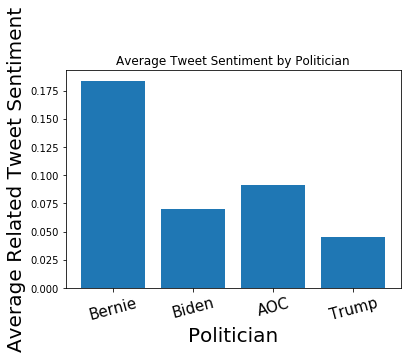

In [35]:
plot_sent()

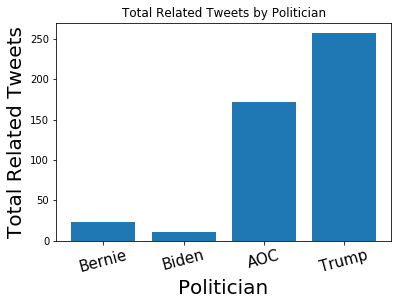

In [37]:
plot_numTs()

In [ ]:
'''
Writeup:
---What does the Code Do?---
(Given by comments)

---What are the goals of the program?---
I sought to create a Spark Stream of tweets focused on 4 popular politicians; I only pulled tweets that had a sentiment
greater than 0.25 (positive) or less than -0.25 (negative). I then conducted sentiment analysis on the downloaded tweets
by iterating through my directories and extracting the text from each tweet.

---What was your expected result?---
Speaking of the technology, I expected to be able to pull tweets and conduct sentiment analysis. I had expected more 
tweets to do with Bernie Sanders than were found.

---What issues did you face?---
I absolutely could not figure out how to get the given scala pseduocode to integrate with IntelliJ. While I am familiar
with the tweepy stream, I have never accomplished it using Spark. To pull this off, I tried over 4 methods until I finally
found this solution. This solution works by using one Python program (given in the TweetRead.py second input) through 
terminal to create and open a stream socket to recieve input. We then used another thread on the same SparkContext to
process and pull in the tweet Status objects as RDDs and my own program to iterate through it and conduct sentiment
analysis. Getting the file name strings correct was very cumbersome. 
Also, each time we had to start/stop the stream, I'd have to execute/keyboard cancel the TweetRead.py program in terminal
to open/close the socket and then execute the SparkDemo.py (In[1]) Jupyter Notebook cell in order to start the stream
(which became tiring).

---Analysis of the model you used---
    Benefits
The Spark Stream has a MAJOR advantage over a traditional tweepy stream; because of the power of RDDs, we are able to 
filter tweets through a function WHILE we stream. This is massively superior to the traditional stream in that for a 
traditional stream we cannot process the stream fast enough before more data comes in. 

    Drawbacks
The unfortunate thing about my current implementation is that the RDDs aren't saved and merged into a single repository,
but this could easily be improved upon using Spark filter and reduce operations as well as by changing the naming 
of the directories from saving timestamps to saving a single, consistent file. 

---Analysis of the prediction---
(Given by above graphs)

---How could this be improved?---
Obviously, I could stream more data. I could track more tags. Additionally, there is a distinct possibility that some
of the pulled tweets simulatneously had to do with 2(+) politicians at once, causing some incorrect data to be attributed
to a politician. I could've added another method to check whether this was the case, and if it was, remove the tweet
from our analysis. 
The time of day (midnight) might have affected our results. 
'''